In [1]:
import os
import glob
import yaml
import random
import datetime
import pytz
from tqdm import tqdm

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

# Ambient NO$_2$ Prediction with XGBoost
* Predictions with daily frequency
* Measurements from EEA stations are used as target
* All other variables of the dataset are used as covariates
* $\frac{80}{20}$ train/test split by location

In [5]:
# load the NO2 dataset
sat_data = pd.read_csv("no2_dataset.csv", parse_dates=["SatelliteDatetime", "SurfaceDatetime"])
sat_data = gpd.GeoDataFrame(sat_data, geometry=gpd.points_from_xy(sat_data.SurfaceLongitude, sat_data.SurfaceLatitude))

In [7]:
# drop all observations with negative surface NO2 concentration measurement
sat_data = sat_data[sat_data.SurfaceConcentration >= 0]
sat_data = sat_data.reset_index(drop=True)

In [8]:
# get counts and indices of stations with few observations (we might want to drop those too)
station_counts = sat_data.AirQualityStation.value_counts()
stations_too_few = station_counts[station_counts < 100].index

In [14]:
# select relevant data for model training
features = ["AreaType", "StationType", "SurfaceLongitude", "SurfaceLatitude", "SensingTimeDiff", "Hour", "Weekday", "Month",
            "Altitude", "PopulationDensity", "Temperature", "Precipitation", "Lockdown", "TroposphericNO2ColumnNumberDensity"]

features_categorical_all = ["AreaType", "StationType", "Weekday", "Hour", "Month", "Lockdown"]
features_categorical = [x for x in features_categorical_all if x in features]
target = "SurfaceConcentration"

In [15]:
# select observations that are valid, i.e. no NaNs, positive surface NO2 concentrations
okay_ind = (np.isnan(sat_data[target]) == False) & (sat_data[target] >= 0) 
okay_stations = sat_data[okay_ind].AirQualityStation.unique()

(1618669, (1618669, 23))

In [16]:
X = sat_data.loc[okay_ind, features].copy()
y = sat_data.loc[okay_ind, target].copy()

X.shape, y.shape

((1618669, 14), (1618669,))

In [18]:
# get one-hot encoding of categorical variables
X = pd.get_dummies(X, columns=[f for f in features_categorical if f in X.columns], drop_first=False)

In [20]:
# make train/test split by locations
# get locations for dataset split

train_proportion = 0.2

locs = pd.Series(zip(X.SurfaceLongitude, X.SurfaceLatitude)).unique()
random.shuffle(locs)

split_point = int(len(locs) * train_proportion)
loc_test = locs[0:split_point]
loc_train = locs[split_point:]

# split dataset by locations
l = pd.Series(zip(X.SurfaceLongitude, X.SurfaceLatitude), index=X.index)
train_ind = l.isin(loc_train)
test_ind = l.isin(loc_test)

In [21]:
# Scale numeric variables to zero mean and unit variance
columns_to_scale_all = ["TroposphericNO2ColumnNumberDensity", "SensingTimeDiff", "Temperature", "Precipitation", "Altitude", 
                        "PopulationDensity", "SurfaceLongitude", "SurfaceLatitude"]
columns_to_scale = [x for x in columns_to_scale_all if x in X.columns]

if columns_to_scale:
    scaler = StandardScaler()
    X.loc[train_ind, columns_to_scale] = scaler.fit_transform(X.loc[train_ind, columns_to_scale])
    X.loc[test_ind, columns_to_scale] = scaler.transform(X.loc[test_ind, columns_to_scale])

scaler_eea = StandardScaler()

# scale target
y.loc[train_ind] = scaler_eea.fit_transform(y.loc[train_ind].values.reshape(-1, 1)).flatten()
y.loc[test_ind] = scaler_eea.transform(y.loc[test_ind].values.reshape(-1, 1)).flatten()

train, test sizes before: 1302061 316608
y: (1618669,)
train ind: (1618669,)


In [26]:
# set train and test sets
X_train = X[train_ind]
y_train = y[train_ind]
X_test = X[test_ind]
y_test = y[test_ind]

print(f"Train: X: {X_train.shape} y: {y_train.shape}")
print(f"Test X {X_test.shape} y: {y_test.shape}")

Train: X: (1302061, 59) y: (1302061,)
Test X (316608, 59) y: (316608,)


In [27]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [30]:
# initialize model
regr = XGBRegressor()

In [31]:
# fit and score xgboost model
regr.fit(X_train, y_train)
print("R2-Score:", regr.score(X_test, y_test))

R2-Score: 0.5270269353488392


In [32]:
# do k fold CV
k = 5
scores = cross_val_score(regr, X, y, cv=k, n_jobs=5)
print(f"scores: {scores} \nmean: {scores.mean()} std: {scores.std()}")

scores: [0.56974306 0.54100825] 
mean: , 0.555375653911561 std: 0.014367407799562248


In [33]:
# get feature importances
imp = pd.DataFrame(columns=["Feature", "Importance"], data=list(zip(X.columns, regr.feature_importances_)))
imp.sort_values(by="Importance", inplace=True, ascending=False)
imp.head()

,Feature,Importance
16,StationType_traffic,0.313620
7,TroposphericNO2ColumnNumberDensity,0.094332
13,AreaType_urban,0.074402
12,AreaType_suburban,0.037872
38,Month_1,0.036386


In [34]:
# save predictions for test and train set
y_hat = regr.predict(X_test)
y_hat_train = regr.predict(X_train)

In [35]:
# scale predictions back to input domain
# set index s.t. it references back to sat_data
y_hat_scaled_s = pd.Series(index=y_test.index, data=scaler_eea.inverse_transform(np.array(y_hat).reshape(-1,1)).flatten())
y_hat_train_scaled_s = pd.Series(index=y_train.index, data=scaler_eea.inverse_transform(np.array(y_hat_train).reshape(-1,1)).flatten())

y_test_scaled_s = pd.Series(index=y_test.index, data=scaler_eea.inverse_transform(np.array(y_test).reshape(-1,1)).flatten())
y_train_scaled_s = pd.Series(index=y_train.index, data=scaler_eea.inverse_transform(np.array(y_train).reshape(-1,1)).flatten())

In [59]:
# print performance metrics (for single prediction, not for CV)
performances = []
for split, y, y_hat in [("Test", y_test_scaled_s, y_hat_scaled_s), ("Train", y_train_scaled_s, y_hat_train_scaled_s)]:
    metrics = [split]
    metrics.extend([perf_measure(y, y_hat) for perf_measure in [r2_score, mean_absolute_error, mean_squared_error]])
    performances.append(metrics)

In [60]:
performances = pd.DataFrame(data=performances, columns = ["Set", "R2-Score", "MAE", "MSE"]).set_index("Set")

In [61]:
performances

,R2-Score,MAE,MSE
Set,,,
Test,0.527027,5.919729,90.055684
Train,0.671514,5.156549,67.122369


In [63]:
# create dataframe for plotting
y_test_scaled_s.name, y_hat_scaled_s.name = "NO2_measurement", "NO2_prediction"
station_types = sat_data.loc[y_test_scaled_s.index].StationType
data = pd.concat([y_test_scaled_s, y_hat_scaled_s, station_types], axis=1)

In [65]:
# set seaborn params
sns_context = {'lines.linewidth': 1}#, 'lines.markersize': 10}                  
sns.set_context("paper", rc = sns_context)  

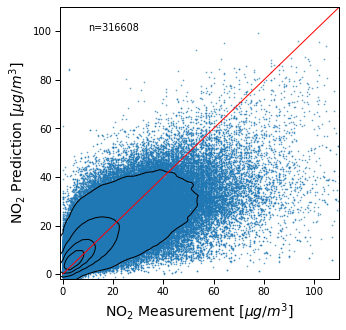

In [68]:
# plot predictions vs. measurements
# kde plot may take a while for lots of datapoints

# restrict plotting to reasonable range (>99% of data)
max_val = 110

fig, ax = plt.subplots(1, figsize=(5,5))
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

ax.scatter(data.NO2_measurement, data.NO2_prediction, s=1, alpha=0.5)
ax.plot((0,max_val), (0,max_val), c="red")

# add contour lines from kde
sns.kdeplot(data=data, x="NO2_measurement", y="NO2_prediction", ax=ax, levels=5, color="black")

ax.text(10, 100, "n="+str(data.shape[0]))
ax.set_xlim((-1, max_val))
ax.set_ylim((-2, max_val))
ax.set_xlabel("NO$_2$ Measurement [$\mu g/ m^{3}$]", fontsize=14)
ax.set_ylabel("NO$_2$ Prediction [$\mu g/ m^{3}$]", fontsize=14)

plt.show()